https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans

In [4]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [5]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [6]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [7]:
from torch.utils.data import Dataset
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2

HFLIP = 'T'  # Or 'F', based on your requirement
HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            # Since albumentations requires numpy arrays, convert the image to a numpy array first
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label

# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.HorizontalFlip(p=HFLIPVAL),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}

Training Images:


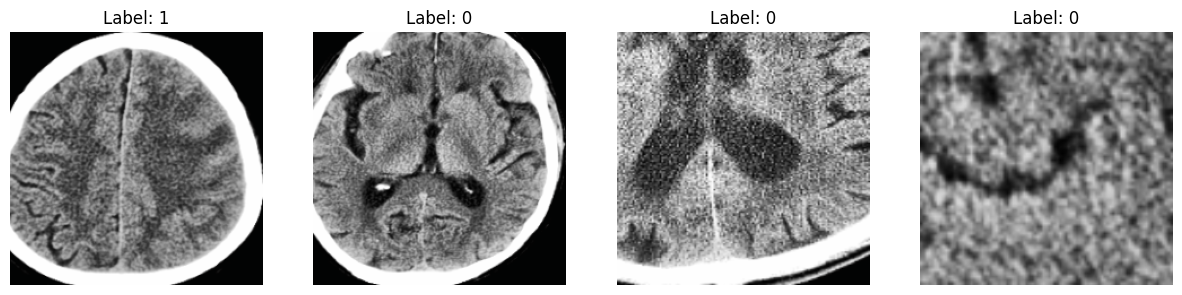

Validation Images:


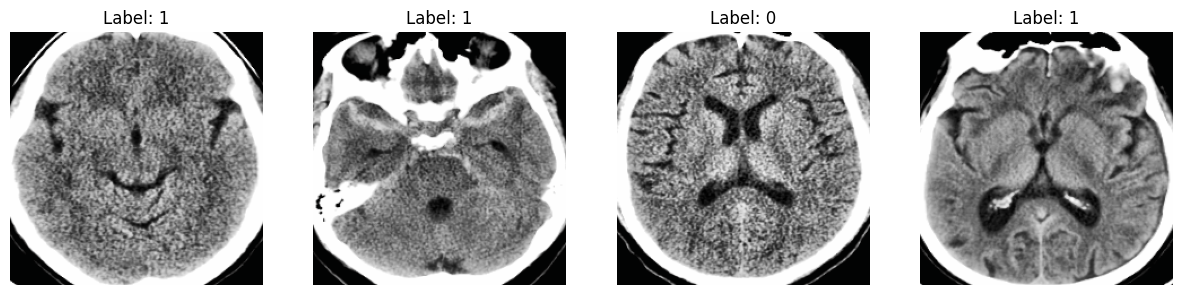

In [8]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction HugginFace pre-trained model


In [9]:
from transformers import AutoConfig, AutoModel


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load configuration and model
config = AutoConfig.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\\models--DunnBC22--vit-base-patch16-224-in21k_covid_19_ct_scans')
vit_model = AutoModel.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\\models--DunnBC22--vit-base-patch16-224-in21k_covid_19_ct_scans', config=config)

for param in vit_model.parameters():
    param.requires_grad = False

vit_model

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


Some weights of ViTModel were not initialized from the model checkpoint at C:\LMS\8\project\Medical student\CQ500_data\models\\models--DunnBC22--vit-base-patch16-224-in21k_covid_19_ct_scans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [10]:
# Modify the custom model to work with ViT
class ModifiedViTModel(nn.Module):
    def __init__(self, vit_model):
        super(ModifiedViTModel, self).__init__()
        self.vit_model = vit_model
        self.classifier = nn.Linear(768, 2)  # Assuming 768 is the embedding size

    def forward(self, x):
        vit_outputs = self.vit_model(x)  # this gives you ViTModelOutput
        # Extract the appropriate tensor. Assuming pooler_output is what you want:
        x = vit_outputs.pooler_output
        x = self.classifier(x)
        return x

model = ModifiedViTModel(vit_model).to(device)

In [11]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
ModifiedViTModel                                        --
├─ViTModel: 1-1                                         --
│    └─ViTEmbeddings: 2-1                               152,064
│    │    └─ViTPatchEmbeddings: 3-1                     (590,592)
│    │    └─Dropout: 3-2                                --
│    └─ViTEncoder: 2-2                                  --
│    │    └─ModuleList: 3-3                             (85,054,464)
│    └─LayerNorm: 2-3                                   (1,536)
│    └─ViTPooler: 2-4                                   --
│    │    └─Linear: 3-4                                 (590,592)
│    │    └─Tanh: 3-5                                   --
├─Linear: 1-2                                           1,538
Total params: 86,390,786
Trainable params: 1,538
Non-trainable params: 86,389,248

In [8]:
import time
import copy
from tqdm.auto import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Here we will save the metrics
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1), desc="Epochs"):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} epoch {epoch}", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train|
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store the loss and accuracy values
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [9]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
----------


train Loss: 0.6438 Acc: 0.6321


Epochs:  20%|██        | 1/5 [00:59<03:58, 59.54s/it]

valid Loss: 0.6330 Acc: 0.6541

Epoch 2/5
----------


train Loss: 0.6161 Acc: 0.6753


Epochs:  40%|████      | 2/5 [01:49<02:41, 53.81s/it]

valid Loss: 0.6238 Acc: 0.6658

Epoch 3/5
----------


train Loss: 0.5963 Acc: 0.6909


Epochs:  60%|██████    | 3/5 [02:39<01:44, 52.22s/it]

valid Loss: 0.6162 Acc: 0.6599

Epoch 4/5
----------


train Loss: 0.5927 Acc: 0.6865


Epochs:  80%|████████  | 4/5 [03:28<00:50, 50.90s/it]

valid Loss: 0.6222 Acc: 0.6591

Epoch 5/5
----------


train Loss: 0.5904 Acc: 0.6951


Epochs: 100%|██████████| 5/5 [04:17<00:00, 51.49s/it]

valid Loss: 0.6105 Acc: 0.6616

Training complete in 4m 20s
Best valid accuracy: 0.665827


In [33]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[575 108]
 [288 220]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.67      0.84      0.74       683
           1       0.67      0.43      0.53       508

    accuracy                           0.67      1191
   macro avg       0.67      0.64      0.64      1191
weighted avg       0.67      0.67      0.65      1191



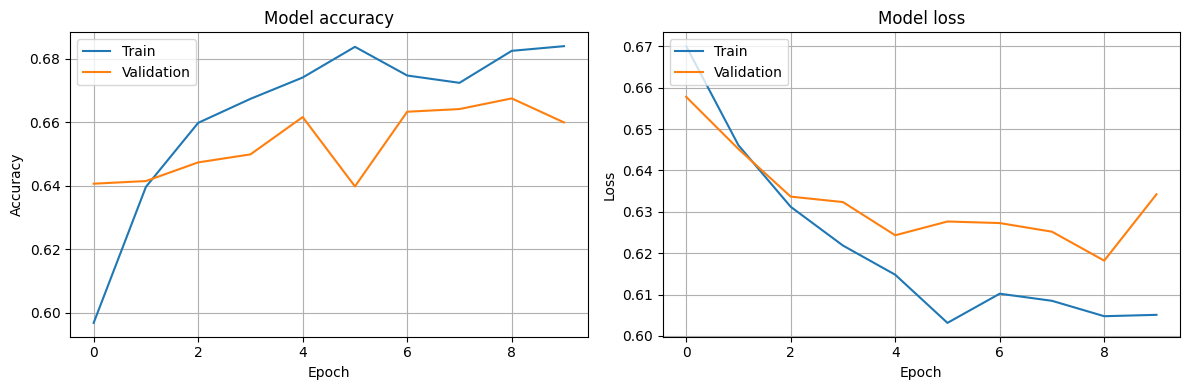

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [18]:
model.state_dict()

OrderedDict([('vit_model.embeddings.cls_token',
              tensor([[[-1.2465e-03,  6.8685e-03, -2.4676e-01,  4.5031e-03,  3.7448e-01,
                         4.6176e-02, -1.1949e-02,  1.0573e-02,  3.2408e-02, -2.0627e-01,
                        -6.7369e-03, -7.5728e-03, -7.6493e-03, -1.0251e-02, -1.2926e-02,
                        -6.4564e-03,  5.2718e-04,  6.4477e-02,  3.1068e-02, -3.8105e-03,
                        -5.4308e-02, -2.8734e-03, -2.5955e-03, -1.8412e-02, -2.3485e-04,
                         5.2871e-02,  3.7488e-03, -1.2328e-02,  3.9768e-02, -3.0639e-02,
                        -4.6675e-04,  1.9472e-02, -1.6957e-02,  1.1188e-02,  2.2552e-02,
                        -7.3993e-04,  4.5310e-02,  2.4576e-03,  1.5185e-03,  8.4335e-03,
                         4.8863e-03,  1.0251e-02,  1.8046e-02,  3.3184e-03,  6.2685e-02,
                         4.0503e-01, -2.6185e-03,  1.1029e-02,  2.5073e-02, -2.1352e-03,
                        -9.1695e-03, -4.9829e-02,  4.9247e-03,

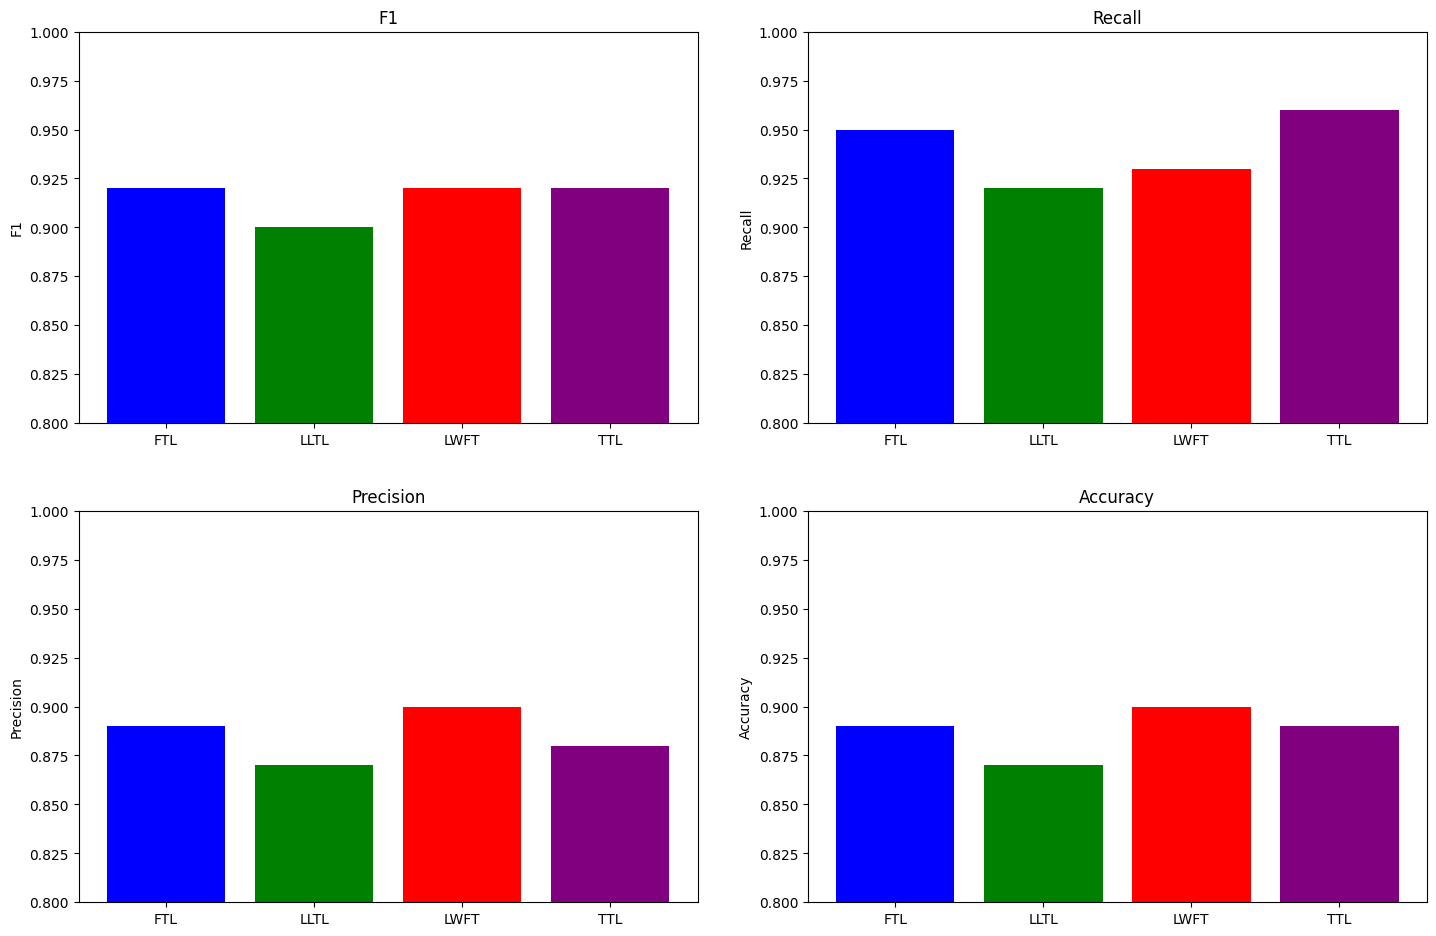

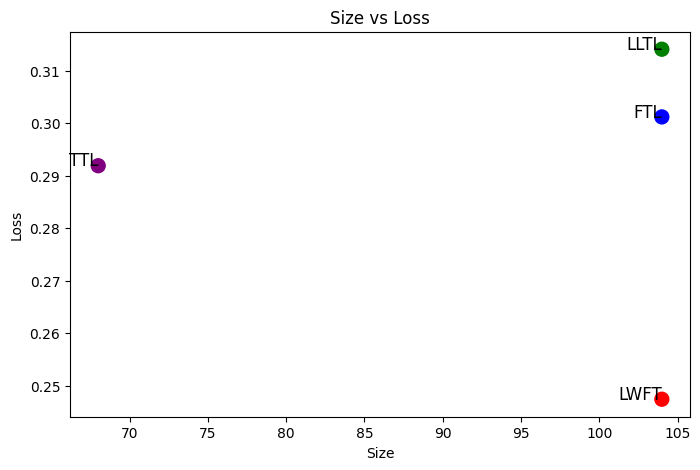

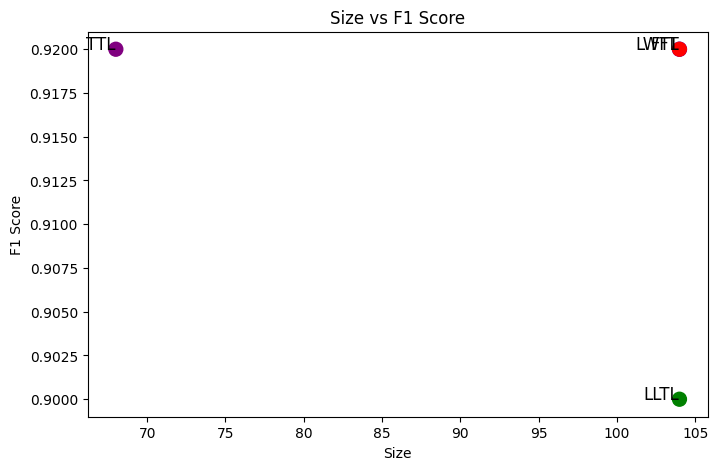

In [2]:
# Updated data
data_updated = {
    'Size': [104, 104, 104, 68],
    'Loss': [0.3012, 0.3141, 0.2474, 0.2919],
    'F1': [0.92, 0.90, 0.92, 0.92],
    'Recall': [0.95, 0.92, 0.93, 0.96],
    'Precision': [0.89, 0.87, 0.90, 0.88],
    'Accuracy': [0.89, 0.87, 0.90, 0.89],
    'Model': ['FTL', 'LLTL', 'LWFT', 'TTL']
}

# Bar chart for each metric by model
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, metric in zip(axs.ravel(), metrics):
    ax.bar(data_updated['Model'], data_updated[metric], color=['blue', 'green', 'red', 'purple'])
    ax.set_title(metric)
    ax.set_ylim(0.8, 1)
    ax.set_ylabel(metric)

fig.tight_layout(pad=3.0)

# Scatter plot showing relationship between Size and Loss
plt.figure(figsize=(8, 5))
plt.scatter(data_updated['Size'], data_updated['Loss'], color=['blue', 'green', 'red', 'purple'], s=100)
for i, model in enumerate(data_updated['Model']):
    plt.annotate(model, (data_updated['Size'][i], data_updated['Loss'][i]), fontsize=12, ha='right')
plt.xlabel('Size')
plt.ylabel('Loss')
plt.title('Size vs Loss')

# Scatter plot showing relationship between Size and F1 Score
plt.figure(figsize=(8, 5))
plt.scatter(data_updated['Size'], data_updated['F1'], color=['blue', 'green', 'red', 'purple'], s=100)
for i, model in enumerate(data_updated['Model']):
    plt.annotate(model, (data_updated['Size'][i], data_updated['F1'][i]), fontsize=12, ha='right')
plt.xlabel('Size')
plt.ylabel('F1 Score')
plt.title('Size vs F1 Score')

plt.show()
